# 문제 S-2: RDD를 사용하여 단어빈도 계산

In [1]:
!ls data | grep txt

ds_bigdata_wiki.txt
ds_spark_wiki.txt


In [2]:
import os

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
d = dict()
with open(os.path.join("data", "ds_bigdata_wiki.txt"), encoding='UTF8') as f:
    for sent in f.readlines():
        for word in sent.split():
            if word not in stopwords:
                if word not in d:
                    d[word] = 1
                else:
                    d[word] += 1
dSorted = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
for k, v in dSorted.items():
    if v > 5:
        print(k, dSorted[k])
    else:
        break
                    
            


데이터 21
데이터를 18
빅 14
있다. 9
수 8
데이터의 8
미국 7
통해 7
유권자 6
선거 6
대한 6
빅데이터 6


### Spark version

In [3]:
import pyspark

config = pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
        .builder\
        .master("local")\
        .appName("wordcount")\
        .config(conf=config)\
        .getOrCreate()


21/10/02 12:59:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
textRdd = spark.sparkContext.textFile(os.path.join("data", "ds_bigdata_wiki.txt"))
for i in textRdd.take(2):
    print(i)

Big data
활용사례 및 의의[편집]


In [5]:
stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
wc_stop = textRdd.flatMap(lambda x: x.split())\
                 .filter(lambda x: x.lower() not in stopwords)\
                 .take(10)
for i in wc_stop:
    print(i, end="/")

Big/data/활용사례/의의[편집]/정치/사회[편집]/2008년/미국/대통령/선거[편집]/

In [6]:
wc = textRdd.flatMap(lambda x: x.split())\
            .filter(lambda x: x.lower not in stopwords)\
            .map(lambda x: (x, 1))\
            .reduceByKey(lambda x, y: x + y)\
            .map(lambda x: (x[1], x[0]))\
            .sortByKey(False)\
            .take(15)


/opt/homebrew/Cellar/apache-spark/3.1.2/libexec/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


In [7]:
for i in wc:
    print(i[0], i[1])

21 데이터
18 데이터를
15 및
14 빅
12 등
9 있다.
8 수
8 데이터의
7 미국
7 통해
6 유권자
6 선거
6 대한
6 빅데이터
5 활용한


### 그래프 그리기

findfont: Font family ['Myeongjo'] not found. Falling back to DejaVu Sans.
/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48143 miss

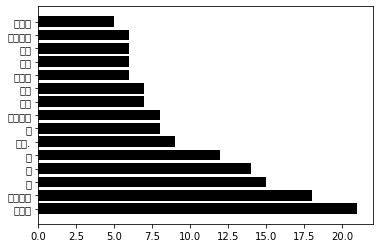

In [8]:
k, v = list(), list()
for i in wc:
    v.append(i[0])
    k.append(i[1])

import matplotlib.pyplot as plt
plt.rc("font", family="Myeongjo")
plt.barh(range(len(v)), v, color="black")
plt.yticks(range(len(v)), k)
plt.show()

In [9]:
from matplotlib import font_manager
for font in font_manager.fontManager.ttflist:
#     print(font.name)
    if "Na" in font.name:
        print(font.name)

Noto Sans Nabataean
Noto Sans Syloti Nagri
Arial Narrow
DecoType Naskh
Arial Narrow
Arial Narrow
Nadeem
Noto Nastaliq Urdu
Arial Narrow


In [10]:
import matplotlib as mpl
print(mpl.matplotlib_fname())

/opt/anaconda3/envs/bigdata_analysis/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc


### combineByKey 사용

In [11]:
testList=[("key1",1),("key1",3),("key2",2),("key1",2),
           ("key2",4),("key1",5),("key2",6),("key1",7),
           ("key1",8),("key2",9),("key2",3)]

testRdd = spark.sparkContext.parallelize(testList)
testRdd.getNumPartitions()

1

In [12]:
testRdd.combineByKey(lambda v: str(v) + "*",
                     lambda c, v: c + "#" + str(v),
                     lambda c1, c2: c1 + "&" + c2
                    ).collect()

[('key1', '1*#3#2#5#7#8'), ('key2', '2*#4#6#9#3')]

### partition이 복수이면 mergeCombiner가 작동

In [13]:
testRdd = spark.sparkContext.parallelize(testList, 2)
partitions = testRdd.glom().collect()
for num, partition in enumerate(partitions):
    print(f"Partition {num} -> {partitions}")

Partition 0 -> [[('key1', 1), ('key1', 3), ('key2', 2), ('key1', 2), ('key2', 4)], [('key1', 5), ('key2', 6), ('key1', 7), ('key1', 8), ('key2', 9), ('key2', 3)]]
Partition 1 -> [[('key1', 1), ('key1', 3), ('key2', 2), ('key1', 2), ('key2', 4)], [('key1', 5), ('key2', 6), ('key1', 7), ('key1', 8), ('key2', 9), ('key2', 3)]]


In [14]:
testRdd.combineByKey(lambda v: str(v) + "*",
                     lambda c, v: c + "#" + str(v),
                     lambda c1, c2: c1 + "&" + c2
                    ).collect()

[('key1', '1*#3#2&5*#7#8'), ('key2', '2*#4&6*#9#3')]

In [15]:
testRdd.combineByKey(lambda value: (value, 1),
                     lambda x, value: (x[0] + value, x[1] + 1),
                     lambda x, y: (x[0]+y[0], x[1]+y[1])
                    ).collect()

[('key1', (26, 6)), ('key2', (24, 5))]

In [16]:
_testCbkRdd = testRdd.combineByKey(lambda value: (value, 1),
                                   lambda x, value: (x[0]+value, x[1]+1),
                                   lambda x, y: (x[0]+y[0], x[1]+y[1])
                                  )
print(_testCbkRdd)

PythonRDD[31] at RDD at PythonRDD.scala:53


In [17]:
averageByMap = _testCbkRdd.map(lambda x: (x[0], x[1][0]/x[1][1]))
print(averageByMap.collectAsMap())

{'key1': 4.333333333333333, 'key2': 4.8}


In [18]:
marks = spark.sparkContext.parallelize([('kim',86),('lim',87),('kim',75),
                                      ('kim',91),('lim',78),('lim',92),
                                      ('lim',79),('lee',99)])

In [21]:
marksByKey = marks.combineByKey(lambda value: (value, 1),
                                lambda x, value: (x[0]+value, x[1]+1),
                                lambda x, y: (x[0]+y[0], x[1]+y[1])
                               )
marksByKey.collect()

/opt/homebrew/Cellar/apache-spark/3.1.2/libexec/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


[('kim', (252, 3)), ('lim', (336, 4)), ('lee', (99, 1))]